In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

## Explore the Example Data

In [ ]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-12-29 09:09:28--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1409:12:285::e59, 2600:1409:12:2af::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   237MB/s    in 3.4s    

2020-12-29 09:09:32 (234 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



Use the OS library to use Operating System libraries, giving you access to the file system 

In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [ ]:
# Let's use os.mkdir to create your directories
# a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir(os.path.join("/tmp", "cats-v-dogs"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs", "training"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs", "testing"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/training", "cats"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/training", "dogs"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/testing", "cats"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/testing", "dogs"))
except OSError:
    print('OSError')
    pass

In [ ]:
# Let's make a function that takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion

# The files should also be randomized,
# Also -- All images should be checked if file length is not 0,

# random.sample(list, len(list)) shuffles a list
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    size = int(SPLIT_SIZE * len(os.listdir(SOURCE)))
    image_list = os.listdir(SOURCE)
    
    image_list = random.sample(image_list, len(image_list))
    train_files = image_list[:size]
    test_files = image_list[size:]
    
    #train_files = random.sample(image_list, int(size))          
    #test_files = [x for x in image_list if x not in train_files]
    for file in train_files:
        path_file = os.path.join(SOURCE, file)
        dest_file_train = os.path.join(TRAINING, file)
        if os.path.getsize(path_file) != 0 :
            copyfile(path_file, dest_file_train)               
    for file in test_files:
        path_file = os.path.join(SOURCE, file)
        dest_file_test = os.path.join(TESTING, file)
        if os.path.getsize(path_file) != 0 :
            copyfile(path_file, dest_file_test) 

In [ ]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11249
11249
1251
1251


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'  

train_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR ='/tmp/cats-v-dogs/testing'  

validation_datagen = ImageDataGenerator( rescale = 1.0/255. ) 

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              epochs=3,
                              verbose=1,
                              validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
 830/1125 [=====================>........] - ETA: 2:18 - loss: 0.5890 - acc: 0.6827

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 549s 488ms/step - loss: 0.5680 - acc: 0.7010 - val_loss: 0.5745 - val_acc: 0.7186
Epoch 2/3
1125/1125 [==============================] - 549s 488ms/step - loss: 0.4334 - acc: 0.8040 - val_loss: 0.3529 - val_acc: 0.8461
Epoch 3/3
1125/1125 [==============================] - 548s 487ms/step - loss: 0.3554 - acc: 0.8475 - val_loss: 0.3589 - val_acc: 0.8481


No handles with labels found to put in legend.


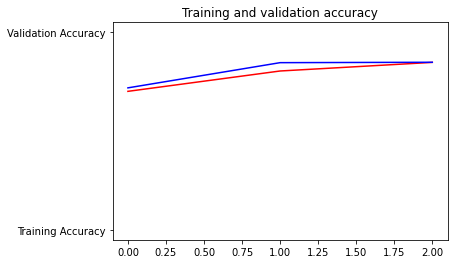

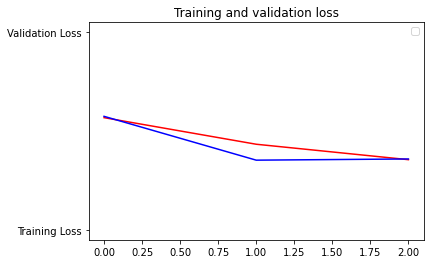

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()
# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(# YOUR CODE HERE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")